100%|██████████| 9.91M/9.91M [00:00<00:00, 37.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.03MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.36MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.48MB/s]



🔹 Training with Sigmoid...
Epoch 1: Loss=0.8707, Val Acc=88.55%
Epoch 2: Loss=0.3707, Val Acc=90.67%
Epoch 3: Loss=0.3225, Val Acc=91.46%
Epoch 4: Loss=0.2990, Val Acc=92.20%
Epoch 5: Loss=0.2822, Val Acc=92.28%
Epoch 6: Loss=0.2676, Val Acc=92.91%
Epoch 7: Loss=0.2540, Val Acc=93.16%
Epoch 8: Loss=0.2412, Val Acc=93.49%
Epoch 9: Loss=0.2281, Val Acc=93.81%
Epoch 10: Loss=0.2164, Val Acc=93.79%

🔹 Training with Tanh...
Epoch 1: Loss=0.4336, Val Acc=91.82%
Epoch 2: Loss=0.2733, Val Acc=92.85%
Epoch 3: Loss=0.2245, Val Acc=94.26%
Epoch 4: Loss=0.1856, Val Acc=95.26%
Epoch 5: Loss=0.1556, Val Acc=95.68%
Epoch 6: Loss=0.1342, Val Acc=96.15%
Epoch 7: Loss=0.1179, Val Acc=96.49%
Epoch 8: Loss=0.1048, Val Acc=96.66%
Epoch 9: Loss=0.0932, Val Acc=96.94%
Epoch 10: Loss=0.0846, Val Acc=97.25%

🔹 Training with ReLU...
Epoch 1: Loss=0.4367, Val Acc=92.93%
Epoch 2: Loss=0.2216, Val Acc=94.92%
Epoch 3: Loss=0.1642, Val Acc=95.80%
Epoch 4: Loss=0.1298, Val Acc=96.37%
Epoch 5: Loss=0.1075, Val Acc=96

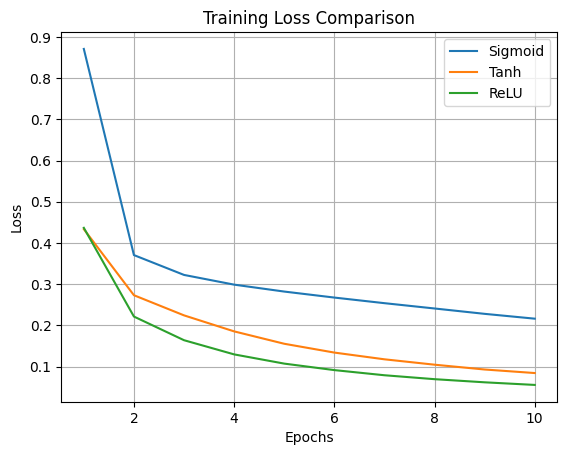

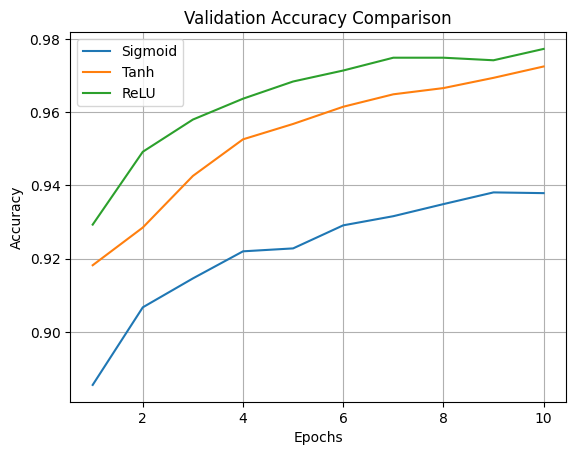

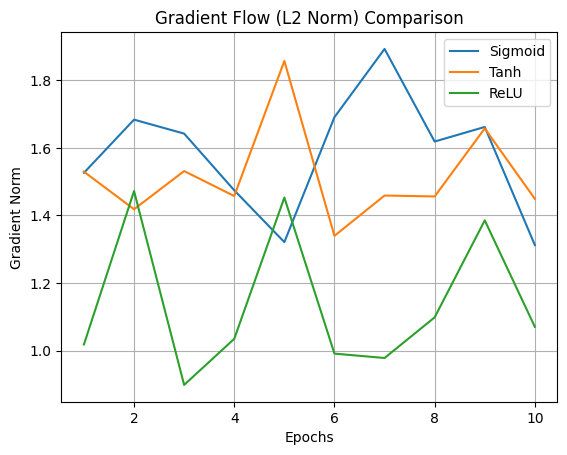

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST
transform = transforms.ToTensor()
train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# MLP Model
class MLP(nn.Module):
    def __init__(self, activation):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.activation = activation
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Train function
def train_model(activation_fn, epochs=10):
    model = MLP(activation_fn).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    criterion = nn.CrossEntropyLoss()

    train_loss, val_acc, grad_norms = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()

            # Track Gradient Norm
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    total_norm += p.grad.data.norm(2).item()
            grad_norms.append(total_norm)

            optimizer.step()
            total_loss += loss.item()

        train_loss.append(total_loss / len(train_loader))

        # Validation accuracy
        model.eval()
        correct = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                preds = model(images).argmax(1)
                correct += (preds == labels).sum().item()

        val_acc.append(correct / len(test_loader.dataset))
        print(f"Epoch {epoch+1}: Loss={train_loss[-1]:.4f}, Val Acc={val_acc[-1]*100:.2f}%")

    return train_loss, val_acc, grad_norms

# Train using all activation functions
activations = {
    "Sigmoid": nn.Sigmoid(),
    "Tanh": nn.Tanh(),
    "ReLU": nn.ReLU()
}

results = {}

for name, act in activations.items():
    print(f"\n🔹 Training with {name}...")
    results[name] = train_model(act)

# Plot function
epochs = range(1, 11)

def plot_metric(index, title, ylabel):
    plt.figure()
    for name in results:
        plt.plot(epochs, results[name][index][:10], label=name)
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

# Plot comparisons
plot_metric(0, "Training Loss Comparison", "Loss")
plot_metric(1, "Validation Accuracy Comparison", "Accuracy")
plot_metric(2, "Gradient Flow (L2 Norm) Comparison", "Gradient Norm")
